# Libraries

In [25]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import data

In [3]:
%run Data_preprocessing_v1.ipynb

************************************************************
There are 6 set of X
X_train_selected_t1, X_train_selected_t2, X_valid_selected_t1,X_valid_selected_t2,X_test_selected_t1,X_test_selected_t2
------------------------------------------------------------
Normalized version
X_train_selected_t1_norm, X_train_selected_t2_norm, X_valid_selected_t1_norm,X_valid_selected_t2_norm,X_test_selected_t1_norm,X_test_selected_t2_norm
------------------------------------------------------------
There are 4 set of Y
y_train_t1, y_train_t2, y_valid_t1, y_valid_t2
when training, please use: 'y_train_t1_value,y_train_t2_value,y_valid_t1_value,y_valid_t2_value'
************************************************************


In [4]:
print(X_train_selected_t2_norm.shape)
print(X_valid_selected_t2_norm.shape)
print(X_test_selected_t2_norm.shape)

(16760, 54)
(2394, 54)
(4790, 54)


# Hyperparameters

In [5]:
input_size = 54
output_size = 1 # live or dead
num_layers = 3
learning_rate = 0.001
batch_size = 32
num_epochs = 500
l2_lamb = 3.736842105263158e-05

# Create JusNN

In [17]:
class JusNN(nn.Module):
    def __init__(self, input_size, num_layers, output_size):
        super(JusNN, self).__init__()
        
        self.fclayers = nn.Sequential(
            nn.Linear(input_size, 3),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(3, 12),
        )
        
        self.batchnorm1 = nn.BatchNorm1d(59)
        
        self.fc1 = nn.Linear(12, 1)
        
    def forward(self, x):
         x1 = F.leaky_relu(self.fclayers(x))
         
         x2 = self.fc1(x1)
         return x2

# Data transform

In [10]:
class CusDatasetLoader(Dataset):
    def __init__(self,x,y):
        self.len = y.shape[0]
        self.x_data = x
        self.y_data = y
  
    def __len__(self):
        return self.len

    def __getitem__(self, index):
        #return self.dataframe.iloc[index]
        return self.x_data[index], self.y_data[index]

In [11]:
# X_shape(X) : used for split the data into a right tensor size
#input: X in shape of 16760 rows × 7488 columns (df)
#output: X in shape of torch.Size([16760, 312, 24]) (tensor)
def X_shape(X):
    X_tensor = torch.from_numpy(np.array(X)).to(torch.float32)
    X_tensor = torch.split(X_tensor,1)
    X_tensor = torch.stack(X_tensor)
    print("X now in shape of",X_tensor.shape)
    return X_tensor

# y_tensor(y) : used for split the data into a right tensor size
#input: X in shape of 16760 rows × 7488 columns (df)
#output: X in shape of torch.Size([16760, 312, 24]) (tensor)
def y_tensor(y):
    y= torch.from_numpy(np.array(y)).to(torch.float32).reshape(len(y),1)
    print("y now in shape of",y.shape)
    return y

In [12]:
# X should be in smaples, 1, squence, rows
X1 = X_shape(X_train_selected_t2_norm)
y1 = y_tensor(y_train_t2.iloc[:,-1])

train_datasets = CusDatasetLoader(X1, y1)
train_loader = DataLoader(dataset=train_datasets, batch_size=batch_size, shuffle=True)

x,y = train_datasets[0]
print(x.shape)
print(y.shape)

X now in shape of torch.Size([16760, 1, 54])
y now in shape of torch.Size([16760, 1])
torch.Size([1, 54])
torch.Size([1])


In [40]:
from torchviz import make_dot
for batch_idx, (data, targets) in enumerate(train_loader):
    if batch_idx ==1:
        batch = data 
yhat = model(batch) # Give dummy batch to forward().
make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

# Model train

In [18]:
model = JusNN(input_size, num_layers, output_size).to(device)

In [20]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

criterion = RMSELoss
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [21]:
losses=[]
acc_list=[]
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.permute(0,1,2)
        #print(data.shape)
        data = data.to(device=device)
        targets = targets.to(device=device)
        targets = torch.squeeze(targets, 1)
        #print(targets)
        
        # forward
        scores = model(data)
        #print(scores.shape)
        loss = criterion(scores, targets)
        l2_lambda = l2_lamb
        l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())
 
        loss = loss + l2_lambda * l2_norm
    
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # gradient descent or adam step
        optimizer.step()
        
    if epoch%5 == 0:
        losses.append(loss.detach().numpy() )
        print(f'Epoch {epoch:03}: | Loss: {loss:.5f} ')
        

Epoch 000: | Loss: 2.00252 
Epoch 005: | Loss: 1.90669 
Epoch 010: | Loss: 1.91172 
Epoch 015: | Loss: 2.02851 
Epoch 020: | Loss: 1.71510 
Epoch 025: | Loss: 1.63440 
Epoch 030: | Loss: 2.05576 
Epoch 035: | Loss: 1.45829 
Epoch 040: | Loss: 1.41631 
Epoch 045: | Loss: 2.12357 
Epoch 050: | Loss: 2.56408 
Epoch 055: | Loss: 2.00228 
Epoch 060: | Loss: 1.90288 
Epoch 065: | Loss: 2.13858 
Epoch 070: | Loss: 1.87541 
Epoch 075: | Loss: 1.92098 
Epoch 080: | Loss: 1.75201 
Epoch 085: | Loss: 1.60578 
Epoch 090: | Loss: 2.59241 
Epoch 095: | Loss: 2.10973 
Epoch 100: | Loss: 2.37758 
Epoch 105: | Loss: 2.25627 
Epoch 110: | Loss: 2.39752 
Epoch 115: | Loss: 1.34266 
Epoch 120: | Loss: 1.57053 
Epoch 125: | Loss: 1.68692 
Epoch 130: | Loss: 1.72217 
Epoch 135: | Loss: 1.73860 
Epoch 140: | Loss: 1.11857 
Epoch 145: | Loss: 2.03662 
Epoch 150: | Loss: 1.75853 
Epoch 155: | Loss: 1.83401 
Epoch 160: | Loss: 1.60887 
Epoch 165: | Loss: 1.57527 
Epoch 170: | Loss: 1.85810 
Epoch 175: | Loss: 1

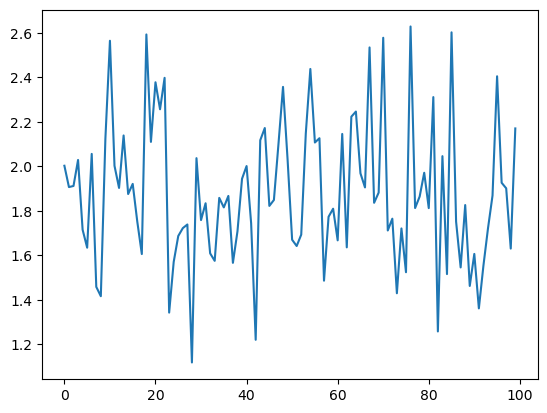

In [26]:
 plt.plot(losses)

# Model RMSE

In [22]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def check_rmse(loader, model):

    # Set model to eval
    model.eval()

    with torch.no_grad():
        for data, targets in loader:
            data = data.permute(0,1,2)
            #print(data.shape)
            data = data.to(device=device)
            targets = targets.to(device=device)
            targets = torch.squeeze(targets, 1)

            scores = model(data)
            res = rmse(scores,targets)
        
            
    # Toggle model back to train
    model.train()
    return res
    

In [23]:
X2 = X_shape(X_valid_selected_t2_norm)
y2 = y_tensor(y_valid_t2.iloc[:,-1])

Valid_datasets = CusDatasetLoader(X2, y2)
Valid_loader = DataLoader(dataset=train_datasets, batch_size=batch_size, shuffle=True)
print(f"RMSE on test set: {check_rmse(Valid_loader, model)}")

X now in shape of torch.Size([2394, 1, 54])
y now in shape of torch.Size([2394, 1])
RMSE on test set: 1.4394893646240234


# Test

In [ ]:
def test(loader, model):
    # Set model to eval
    model.eval()
    res = torch.tensor([], dtype=torch.int64)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).permute(0,2,1)
            print(x.shape)
            y = torch.squeeze(y.to(device=device), 1)
            print(y.shape)

            scores = model(x)
            _, predictions = scores.max(1)
            res =  torch.cat((predictions, res), 0)  
    model.train()
   
    return res

In [ ]:
X_test

In [ ]:
X_test_final = X_shape(X_test)
y_final = torch.zeros([4790,1])

test_datasets = CusDatasetLoader(X_test_final, y_final)
test_loader = DataLoader(dataset=test_datasets, batch_size=batch_size, shuffle=True)

result = test(test_loader, model)
result

In [ ]:

#df.index = ['Row_1', 'Row_2', 'Row_3', 'Row_4']
res1 = pd.DataFrame(result, columns=["Predicted"])
res1.index = X_test.index
res1.index.name = 'Id'
pd.DataFrame(res1).to_csv('out.csv')


#

#

#